# Angular Distribution of Radiation from a Relativistic Charge
This notebook visualizes the **angular distribution of radiation** emitted by an accelerated charge moving relativistically. We consider a charge with velocity **v** along the z-axis and acceleration **a** in an arbitrary direction.


In [63]:
import sys
import numpy as np

!{sys.executable} -m pip install --quiet matplotlib

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


# Physics Background

## 1. Key Parameters

We define:
- $\beta = v/c$ (velocity in units of speed of light)
- $\gamma = 1/\sqrt{1-\beta^2}$ (Lorentz factor)
- $\theta$ = polar angle in lab frame (angle from z-axis)
- $\phi$ = azimuthal angle in lab frame
- $\alpha$ = tilt angle of acceleration from z-axis
- $\phi_a$ = azimuthal angle of acceleration direction

## 2. Observed Angular Distribution

The **observed** radiated power per unit solid angle is:

$$\frac{dP_A}{d\Omega} = \frac{q^2 a'^2}{4\pi c^3} \frac{\sin^2\theta'}{\gamma^4 (1-\beta\cos\theta)^4}$$

where $\theta'$ is the angle in the rest frame, related to lab frame angles by:

$$\cos\theta' = \cos\alpha\cos\Theta + \sin\alpha\sin\Theta\cos(\phi - \phi_a)$$

Here $\Theta$ is related to $\theta$ through aberration:
$$\mu = \cos\theta = \frac{\cos\Theta + \beta}{1 + \beta\cos\Theta}$$

For visualization, we use $\Theta \approx \theta$ as the leading approximation.


# Define Functions


In [64]:
def compute_theta_prime(theta, phi, alpha, phi_a):
    cos_theta_prime = np.cos(alpha) * np.cos(theta) + np.sin(alpha) * np.sin(theta) * np.cos(phi - phi_a)
    cos_theta_prime = np.clip(cos_theta_prime, -1.0, 1.0)
    theta_prime = np.arccos(cos_theta_prime)
    return theta_prime


In [65]:
def angular_distribution(theta, phi, beta, alpha, phi_a):
    gamma = 1.0 / np.sqrt(1.0 - beta**2)
    theta_prime = compute_theta_prime(theta, phi, alpha, phi_a)
    
    numerator = np.sin(theta_prime)**2
    denominator = gamma**4 * (1.0 - beta * np.cos(theta))**4
    denominator = np.maximum(denominator, 1e-10)
    
    F = numerator / denominator
    return F


In [66]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z


# Example: Parallel Acceleration


First, let's visualize the special case where acceleration is parallel to velocity ($\alpha = 0$). In this case, the radiation is strongly beamed in the forward direction for high $\gamma$.


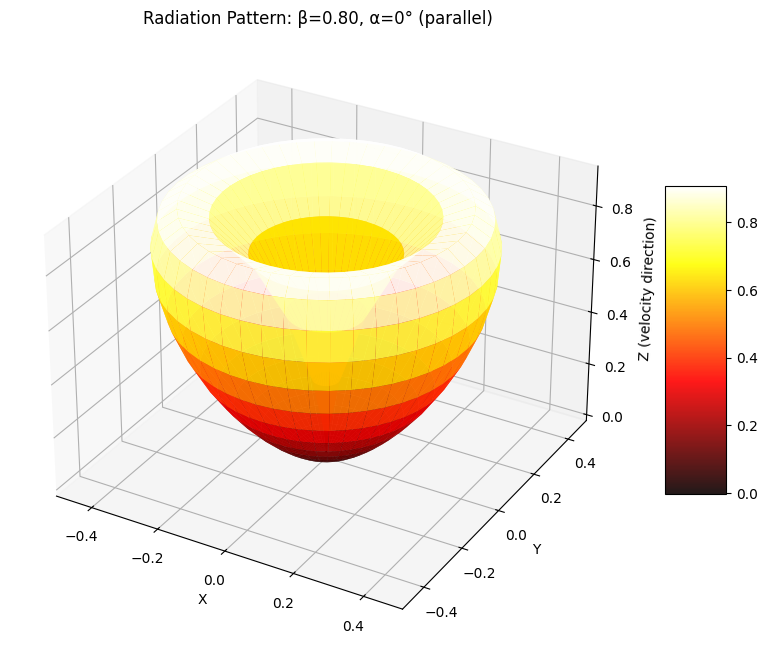

In [67]:
n_theta = 50
n_phi = 50
theta_grid = np.linspace(0, np.pi, n_theta)
phi_grid = np.linspace(0, 2*np.pi, n_phi)
theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)

beta = 0.8
alpha = 0.0
phi_a = 0.0

F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
F_normalized = F / np.max(F)

x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, cmap='hot', alpha=0.9, edgecolor='none')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z (velocity direction)')
ax.set_title(f'Radiation Pattern: β={beta:.2f}, α=0° (parallel)')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


# Interactive 3D Visualization


Now create visualizations exploring how the radiation pattern changes with:
- **γ** (Lorentz factor): Controls the degree of relativistic beaming
- **α** (tilt angle): Angle between acceleration and velocity
- **φ_a** (azimuthal angle): Direction of acceleration in the xy-plane

We'll create a grid of plots showing different parameter combinations.


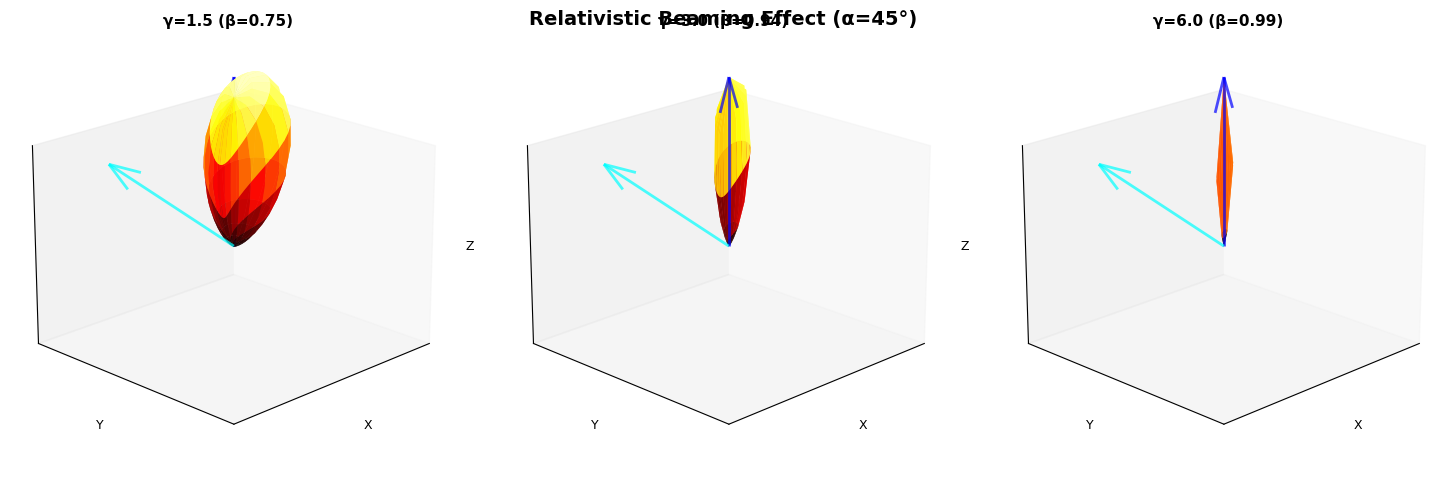

In [68]:
fig = plt.figure(figsize=(15, 5))

gamma_values = [1.5, 3.0, 6.0]
alpha_deg = 45.0
phi_a_deg = 0.0

for i, gamma in enumerate(gamma_values):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    alpha = np.deg2rad(alpha_deg)
    phi_a = np.deg2rad(phi_a_deg)
    beta = np.sqrt(1.0 - 1.0/gamma**2)
    
    n_theta = 40
    n_phi = 40
    theta_grid = np.linspace(0, np.pi, n_theta)
    phi_grid = np.linspace(0, 2*np.pi, n_phi)
    theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)
    
    F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
    F_normalized = F / np.max(F)
    x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)
    
    surf = ax.plot_surface(x, y, z, cmap='hot', alpha=0.9, edgecolor='none', 
                           vmin=0, vmax=1, rcount=30, ccount=30)
    
    acc_length = 1.0
    acc_x = acc_length * np.sin(alpha) * np.cos(phi_a)
    acc_y = acc_length * np.sin(alpha) * np.sin(phi_a)
    acc_z = acc_length * np.cos(alpha)
    ax.quiver(0, 0, 0, acc_x, acc_y, acc_z, color='cyan', arrow_length_ratio=0.2, 
              linewidth=2, alpha=0.7)
    ax.quiver(0, 0, 0, 0, 0, acc_length, color='blue', arrow_length_ratio=0.2, 
              linewidth=2, alpha=0.7)
    
    ax.set_xlabel('X', fontsize=9)
    ax.set_ylabel('Y', fontsize=9)
    ax.set_zlabel('Z', fontsize=9)
    
    title = f'γ={gamma:.1f} (β={beta:.2f})'
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    ax.view_init(elev=20, azim=45)
    
    max_range = 0.6
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.suptitle(f'Relativistic Beaming Effect (α={alpha_deg:.0f}°)', 
             fontsize=14, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()


# Key Physical Insights

## Relativistic Beaming
As γ increases, the radiation becomes increasingly concentrated in the forward direction (along the velocity). This is the **relativistic beaming** effect.

## Acceleration Direction
- **α = 0°** (parallel): Maximum beaming, symmetric about z-axis
- **α = 90°** (perpendicular): Radiation still beamed forward, but with asymmetric lobes
- **α = 180°** (antiparallel): Similar to parallel case but with different intensity

## The Headlight Effect
For large γ, most radiation is emitted within a cone of half-angle $\sim 1/\gamma$ around the velocity direction, regardless of acceleration direction.



# Effect of Acceleration Direction

Explore how the tilt angle α (angle between acceleration and velocity) affects the radiation pattern.


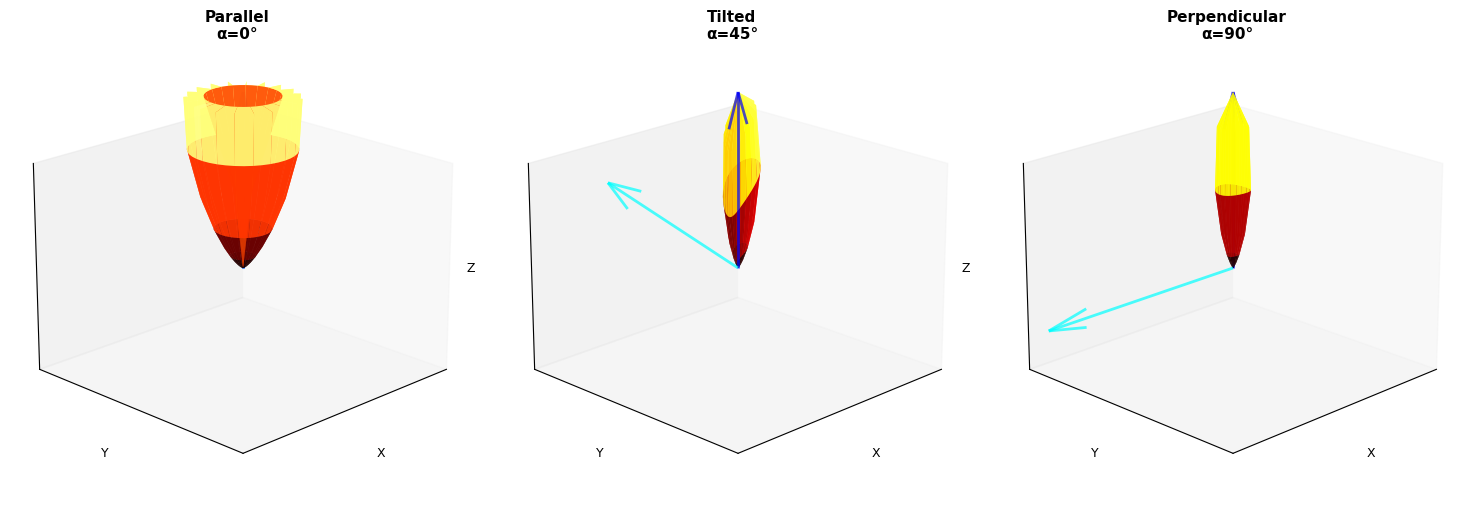

In [69]:
fig = plt.figure(figsize=(15, 5))

gamma = 3.0
alpha_values = [0.0, 45.0, 90.0]
phi_a_deg = 0.0

for i, alpha_deg in enumerate(alpha_values):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    alpha = np.deg2rad(alpha_deg)
    phi_a = np.deg2rad(phi_a_deg)
    beta = np.sqrt(1.0 - 1.0/gamma**2)
    
    n_theta = 40
    n_phi = 40
    theta_grid = np.linspace(0, np.pi, n_theta)
    phi_grid = np.linspace(0, 2*np.pi, n_phi)
    theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)
    
    F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
    F_normalized = F / np.max(F)
    x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)
    
    surf = ax.plot_surface(x, y, z, cmap='hot', alpha=0.9, edgecolor='none',
                           vmin=0, vmax=1, rcount=30, ccount=30)
    
    acc_length = 1.0
    acc_x = acc_length * np.sin(alpha) * np.cos(phi_a)
    acc_y = acc_length * np.sin(alpha) * np.sin(phi_a)
    acc_z = acc_length * np.cos(alpha)
    ax.quiver(0, 0, 0, acc_x, acc_y, acc_z, color='cyan', arrow_length_ratio=0.2,
              linewidth=2, alpha=0.7)
    ax.quiver(0, 0, 0, 0, 0, acc_length, color='blue', arrow_length_ratio=0.2,
              linewidth=2, alpha=0.7)
    
    ax.set_xlabel('X', fontsize=9)
    ax.set_ylabel('Y', fontsize=9)
    ax.set_zlabel('Z', fontsize=9)
    
    if alpha_deg == 0:
        acc_type = "Parallel"
    elif alpha_deg == 90:
        acc_type = "Perpendicular"
    else:
        acc_type = "Tilted"
    
    title = f'{acc_type}\nα={alpha_deg:.0f}°'
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    ax.view_init(elev=20, azim=45)
    
    max_range = 0.6
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

#plt.suptitle(f'Effect of Acceleration Direction (γ={gamma:.1f})',
 #            fontsize=14, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()


# Summary

This notebook demonstrates the angular distribution of radiation from a relativistic accelerated charge. Key features:

1. **Relativistic beaming**: Radiation is concentrated in the forward direction for high γ
2. **Acceleration direction matters**: The tilt angle α and azimuthal angle φₐ affect the pattern shape
3. **Physical origin**: The pattern arises from the Lorentz transformation of dipole radiation from the rest frame
4. **Applications**: Synchrotron radiation, bremsstrahlung, and astrophysical jets

The formula implemented is:

$$\frac{dP_A}{d\Omega} \propto \frac{\sin^2\theta'}{\gamma^4 (1-\beta\cos\theta)^4}$$

where $\theta'$ depends on both the observation direction and the acceleration direction.


# Parameter Sweep: Beta and Alpha Variations

Comprehensive visualization exploring the full parameter space of relativistic velocities (β) and acceleration angles (α).


## Grid 1: Fixed Alpha, Varying Beta

Explore how radiation patterns change with velocity for a fixed acceleration angle.


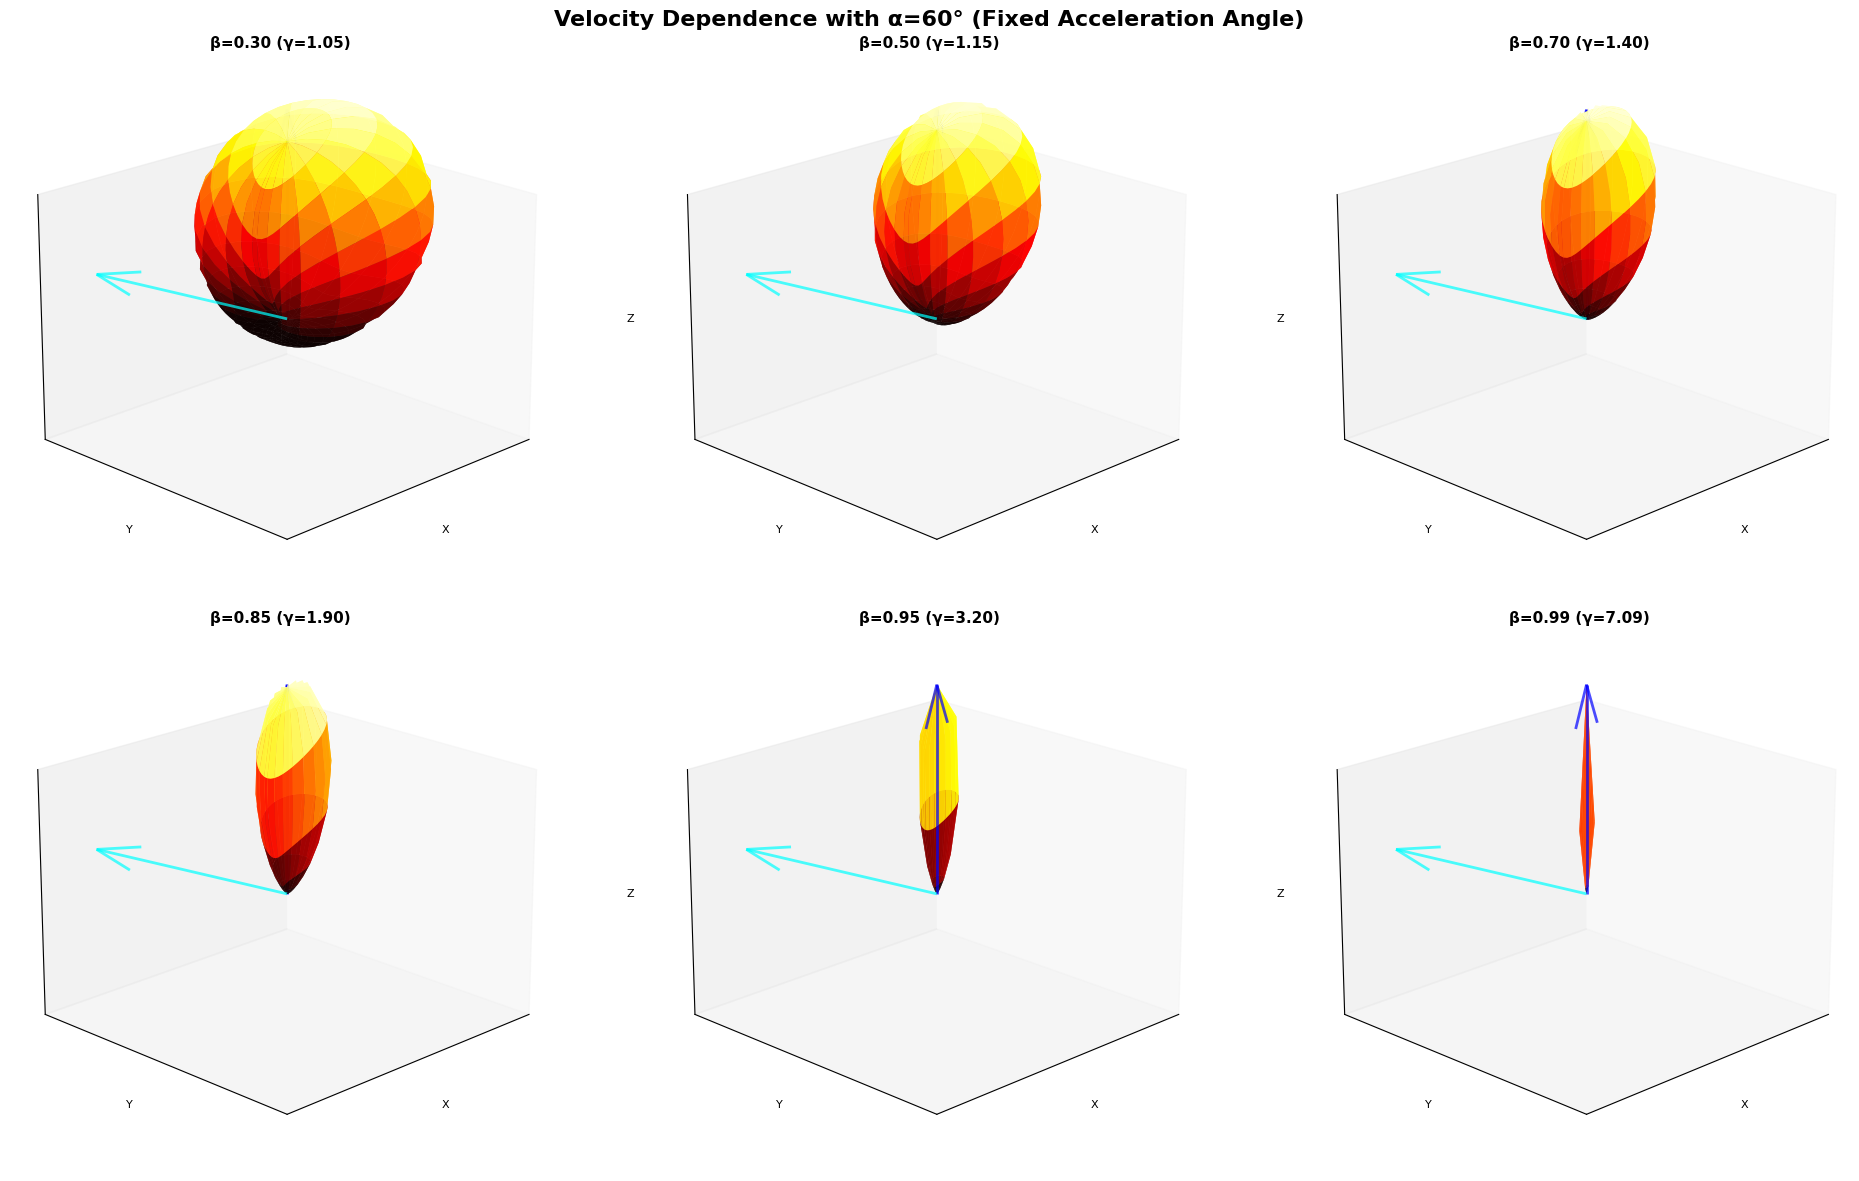

In [70]:
fig = plt.figure(figsize=(20, 12))

beta_values = [0.3, 0.5, 0.7, 0.85, 0.95, 0.99]
alpha_deg = 60.0
phi_a_deg = 0.0

for i, beta in enumerate(beta_values):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    
    alpha = np.deg2rad(alpha_deg)
    phi_a = np.deg2rad(phi_a_deg)
    gamma = 1.0 / np.sqrt(1.0 - beta**2)
    
    n_theta = 40
    n_phi = 40
    theta_grid = np.linspace(0, np.pi, n_theta)
    phi_grid = np.linspace(0, 2*np.pi, n_phi)
    theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)
    
    F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
    F_normalized = F / np.max(F)
    x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)
    
    surf = ax.plot_surface(x, y, z, cmap='hot', alpha=0.9, edgecolor='none', 
                           vmin=0, vmax=1, rcount=30, ccount=30)
    
    acc_length = 1.0
    acc_x = acc_length * np.sin(alpha) * np.cos(phi_a)
    acc_y = acc_length * np.sin(alpha) * np.sin(phi_a)
    acc_z = acc_length * np.cos(alpha)
    ax.quiver(0, 0, 0, acc_x, acc_y, acc_z, color='cyan', arrow_length_ratio=0.2, 
              linewidth=2, alpha=0.7)
    ax.quiver(0, 0, 0, 0, 0, acc_length, color='blue', arrow_length_ratio=0.2, 
              linewidth=2, alpha=0.7)
    
    ax.set_xlabel('X', fontsize=8)
    ax.set_ylabel('Y', fontsize=8)
    ax.set_zlabel('Z', fontsize=8)
    
    title = f'β={beta:.2f} (γ={gamma:.2f})'
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    ax.view_init(elev=20, azim=45)
    
    max_range = 0.6
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.suptitle(f'Velocity Dependence with α={alpha_deg:.0f}° (Fixed Acceleration Angle)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


## Grid 2: Fixed Beta, Varying Alpha

Explore how radiation patterns change with acceleration angle for a fixed velocity.


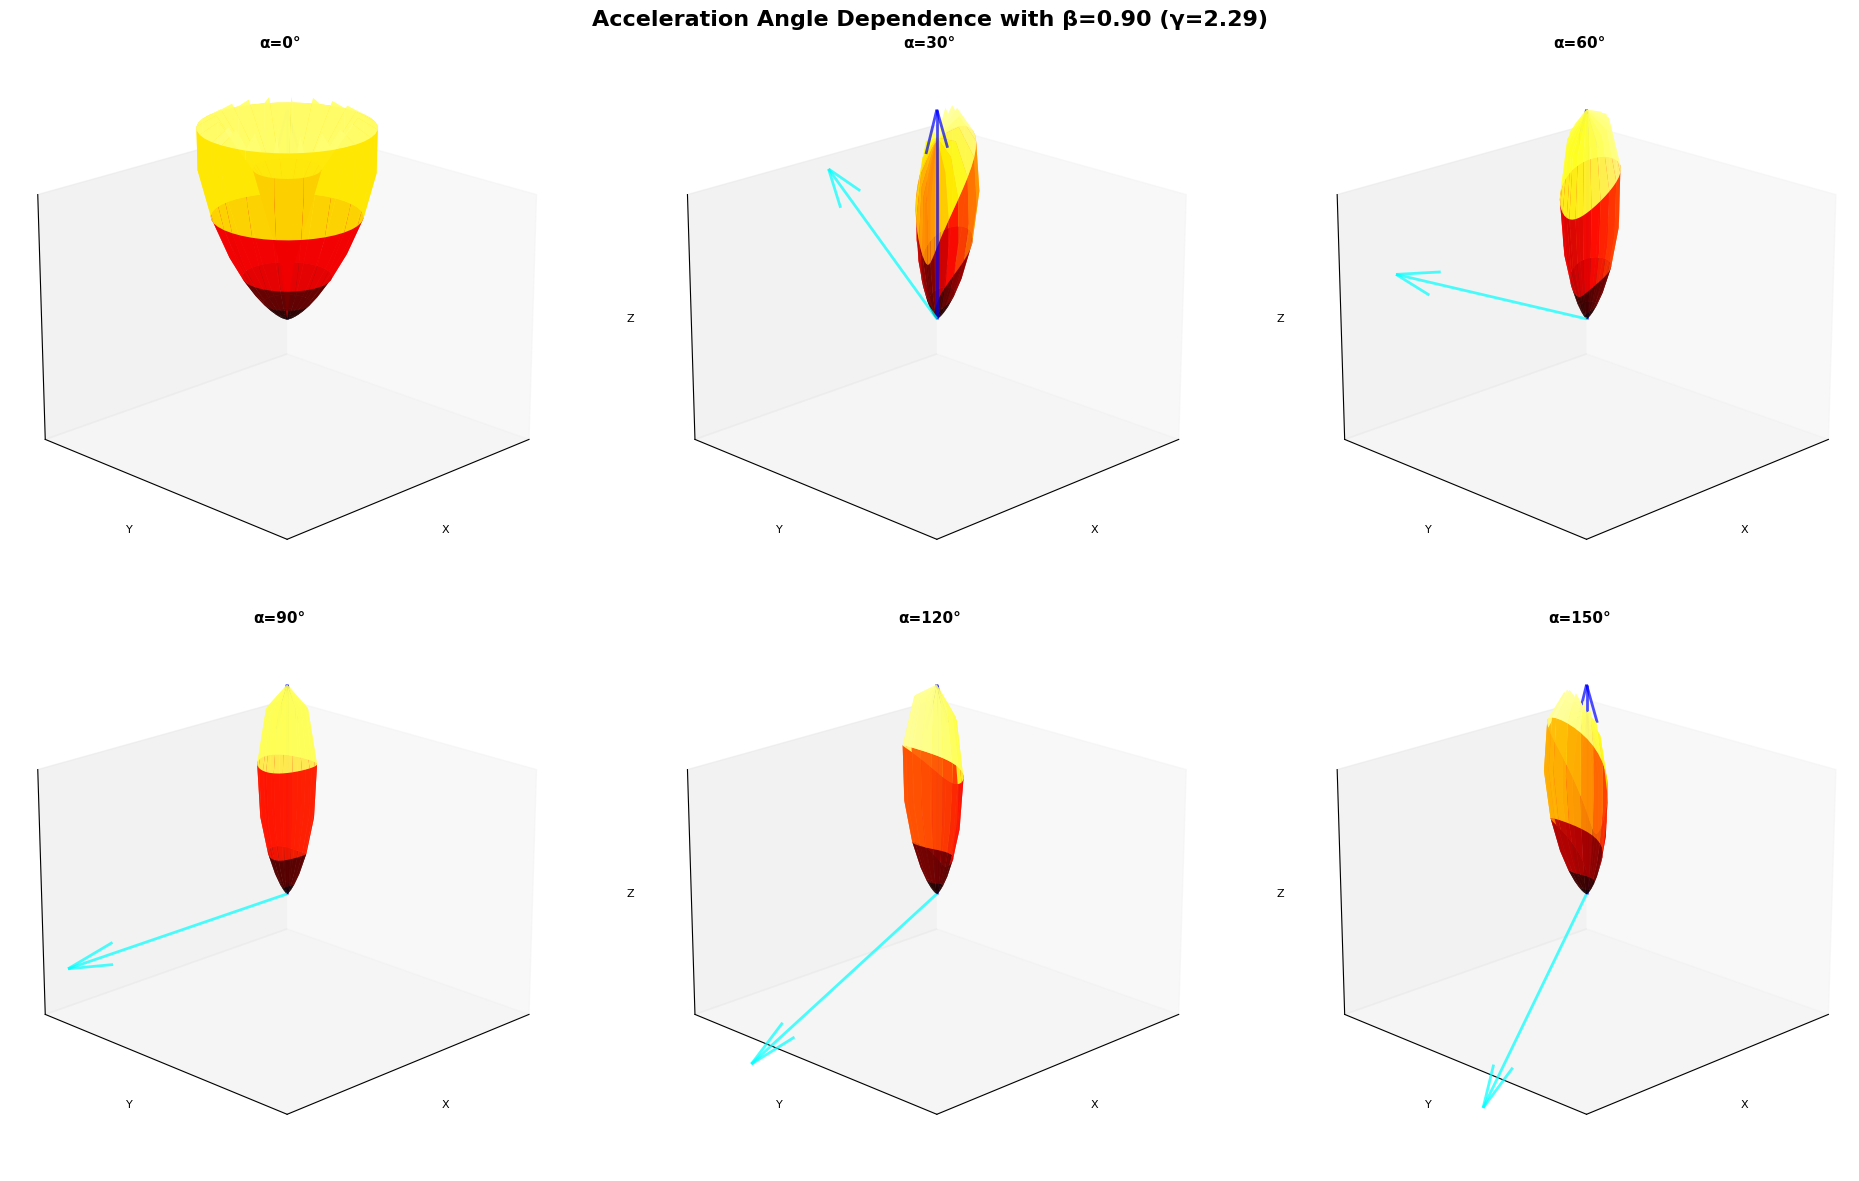

In [71]:
fig = plt.figure(figsize=(20, 12))

alpha_values = [0, 30, 60, 90, 120, 150]
beta = 0.9
phi_a_deg = 0.0

for i, alpha_deg in enumerate(alpha_values):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    
    alpha = np.deg2rad(alpha_deg)
    phi_a = np.deg2rad(phi_a_deg)
    gamma = 1.0 / np.sqrt(1.0 - beta**2)
    
    n_theta = 40
    n_phi = 40
    theta_grid = np.linspace(0, np.pi, n_theta)
    phi_grid = np.linspace(0, 2*np.pi, n_phi)
    theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)
    
    F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
    F_normalized = F / np.max(F)
    x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)
    
    surf = ax.plot_surface(x, y, z, cmap='hot', alpha=0.9, edgecolor='none',
                           vmin=0, vmax=1, rcount=30, ccount=30)
    
    acc_length = 1.0
    acc_x = acc_length * np.sin(alpha) * np.cos(phi_a)
    acc_y = acc_length * np.sin(alpha) * np.sin(phi_a)
    acc_z = acc_length * np.cos(alpha)
    ax.quiver(0, 0, 0, acc_x, acc_y, acc_z, color='cyan', arrow_length_ratio=0.2,
              linewidth=2, alpha=0.7)
    ax.quiver(0, 0, 0, 0, 0, acc_length, color='blue', arrow_length_ratio=0.2,
              linewidth=2, alpha=0.7)
    
    ax.set_xlabel('X', fontsize=8)
    ax.set_ylabel('Y', fontsize=8)
    ax.set_zlabel('Z', fontsize=8)
    
    title = f'α={alpha_deg:.0f}°'
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    ax.view_init(elev=20, azim=45)
    
    max_range = 0.6
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.suptitle(f'Acceleration Angle Dependence with β={beta:.2f} (γ={gamma:.2f})', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


## Grid 3: 2D Polar Plot Comparison

Compare radiation patterns in polar coordinates for different parameter combinations.


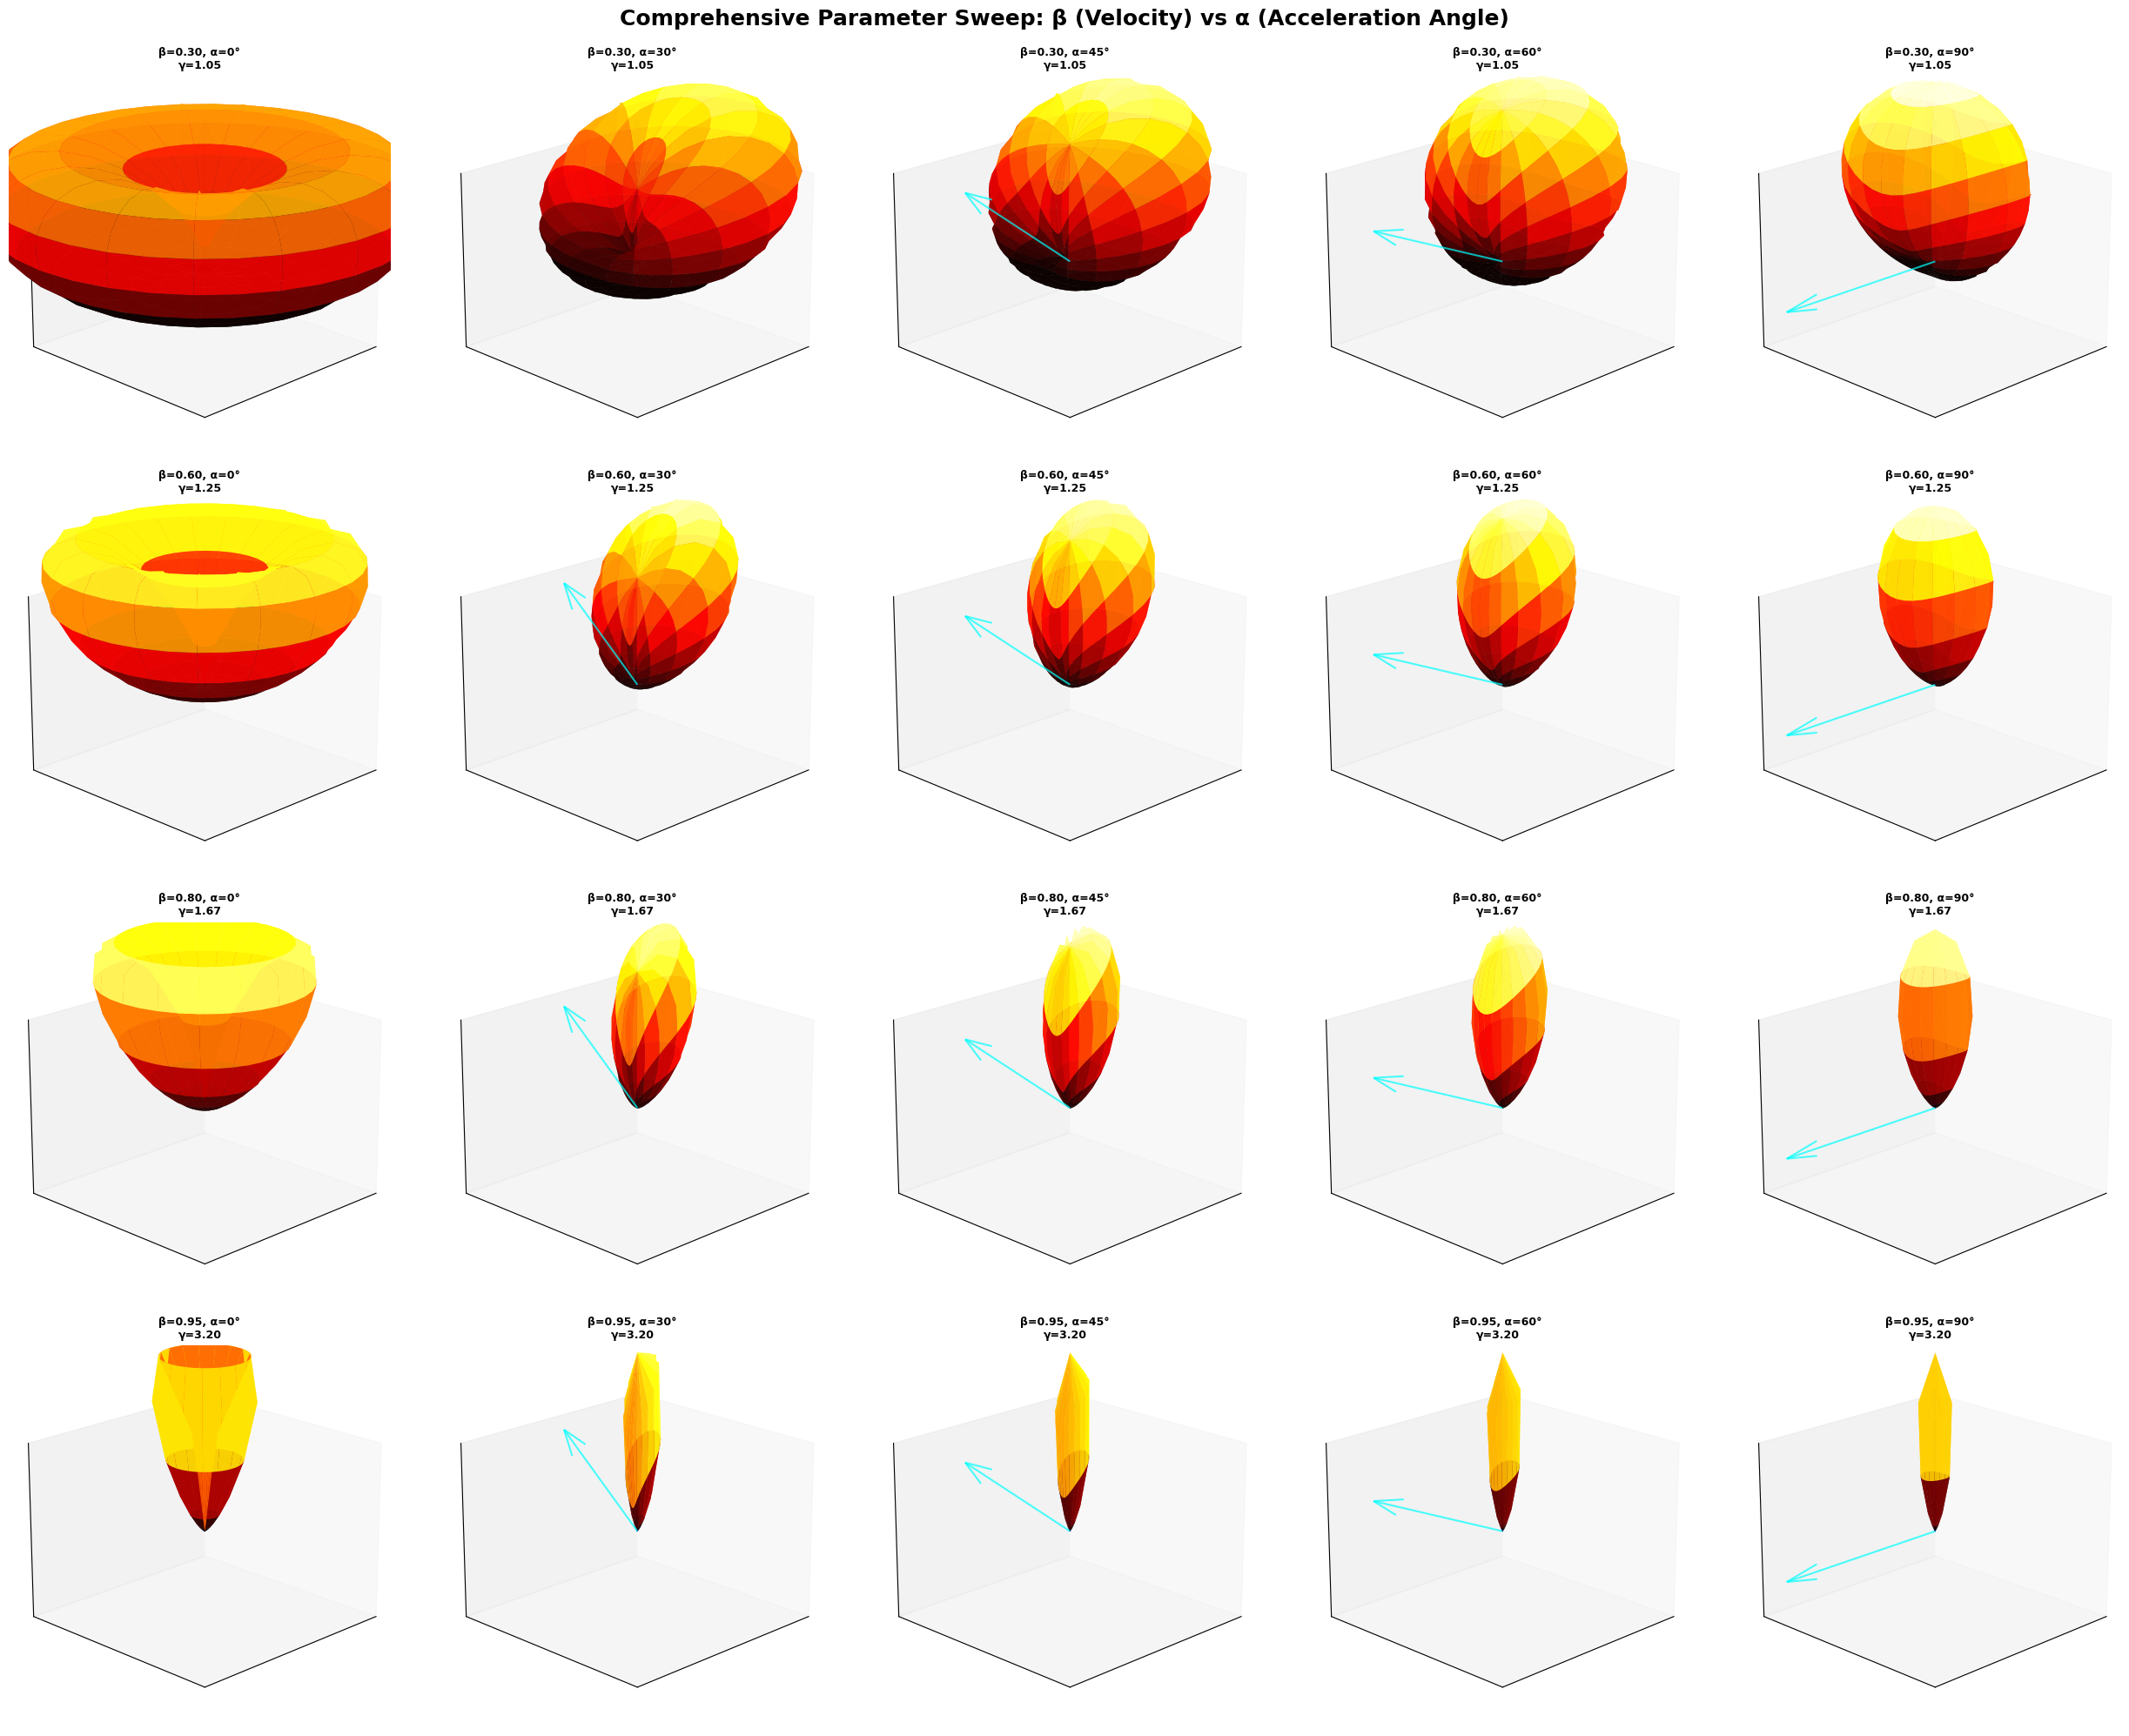

In [72]:
fig = plt.figure(figsize=(25, 20))

beta_values = [0.3, 0.6, 0.8, 0.95]
alpha_values = [0, 30, 45, 60, 90]
phi_a_deg = 0.0

plot_idx = 1
for beta in beta_values:
    for alpha_deg in alpha_values:
        ax = fig.add_subplot(4, 5, plot_idx, projection='3d')
        
        alpha = np.deg2rad(alpha_deg)
        phi_a = np.deg2rad(phi_a_deg)
        gamma = 1.0 / np.sqrt(1.0 - beta**2)
        
        n_theta = 35
        n_phi = 35
        theta_grid = np.linspace(0, np.pi, n_theta)
        phi_grid = np.linspace(0, 2*np.pi, n_phi)
        theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)
        
        F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
        F_normalized = F / np.max(F)
        x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)
        
        surf = ax.plot_surface(x, y, z, cmap='hot', alpha=0.9, edgecolor='none',
                               vmin=0, vmax=1, rcount=25, ccount=25)
        
        acc_length = 0.8
        acc_x = acc_length * np.sin(alpha) * np.cos(phi_a)
        acc_y = acc_length * np.sin(alpha) * np.sin(phi_a)
        acc_z = acc_length * np.cos(alpha)
        ax.quiver(0, 0, 0, acc_x, acc_y, acc_z, color='cyan', arrow_length_ratio=0.2,
                  linewidth=1.5, alpha=0.7)
        ax.quiver(0, 0, 0, 0, 0, acc_length, color='blue', arrow_length_ratio=0.2,
                  linewidth=1.5, alpha=0.7)
        
        title = f'β={beta:.2f}, α={alpha_deg:.0f}°\nγ={gamma:.2f}'
        ax.set_title(title, fontsize=9, fontweight='bold')
        
        ax.view_init(elev=20, azim=45)
        
        max_range = 0.5
        ax.set_xlim([-max_range, max_range])
        ax.set_ylim([-max_range, max_range])
        ax.set_zlim([-max_range, max_range])
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('')
        
        plot_idx += 1

plt.suptitle('Comprehensive Parameter Sweep: β (Velocity) vs α (Acceleration Angle)', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## Grid 4 -  Polar Radiation Patterns  


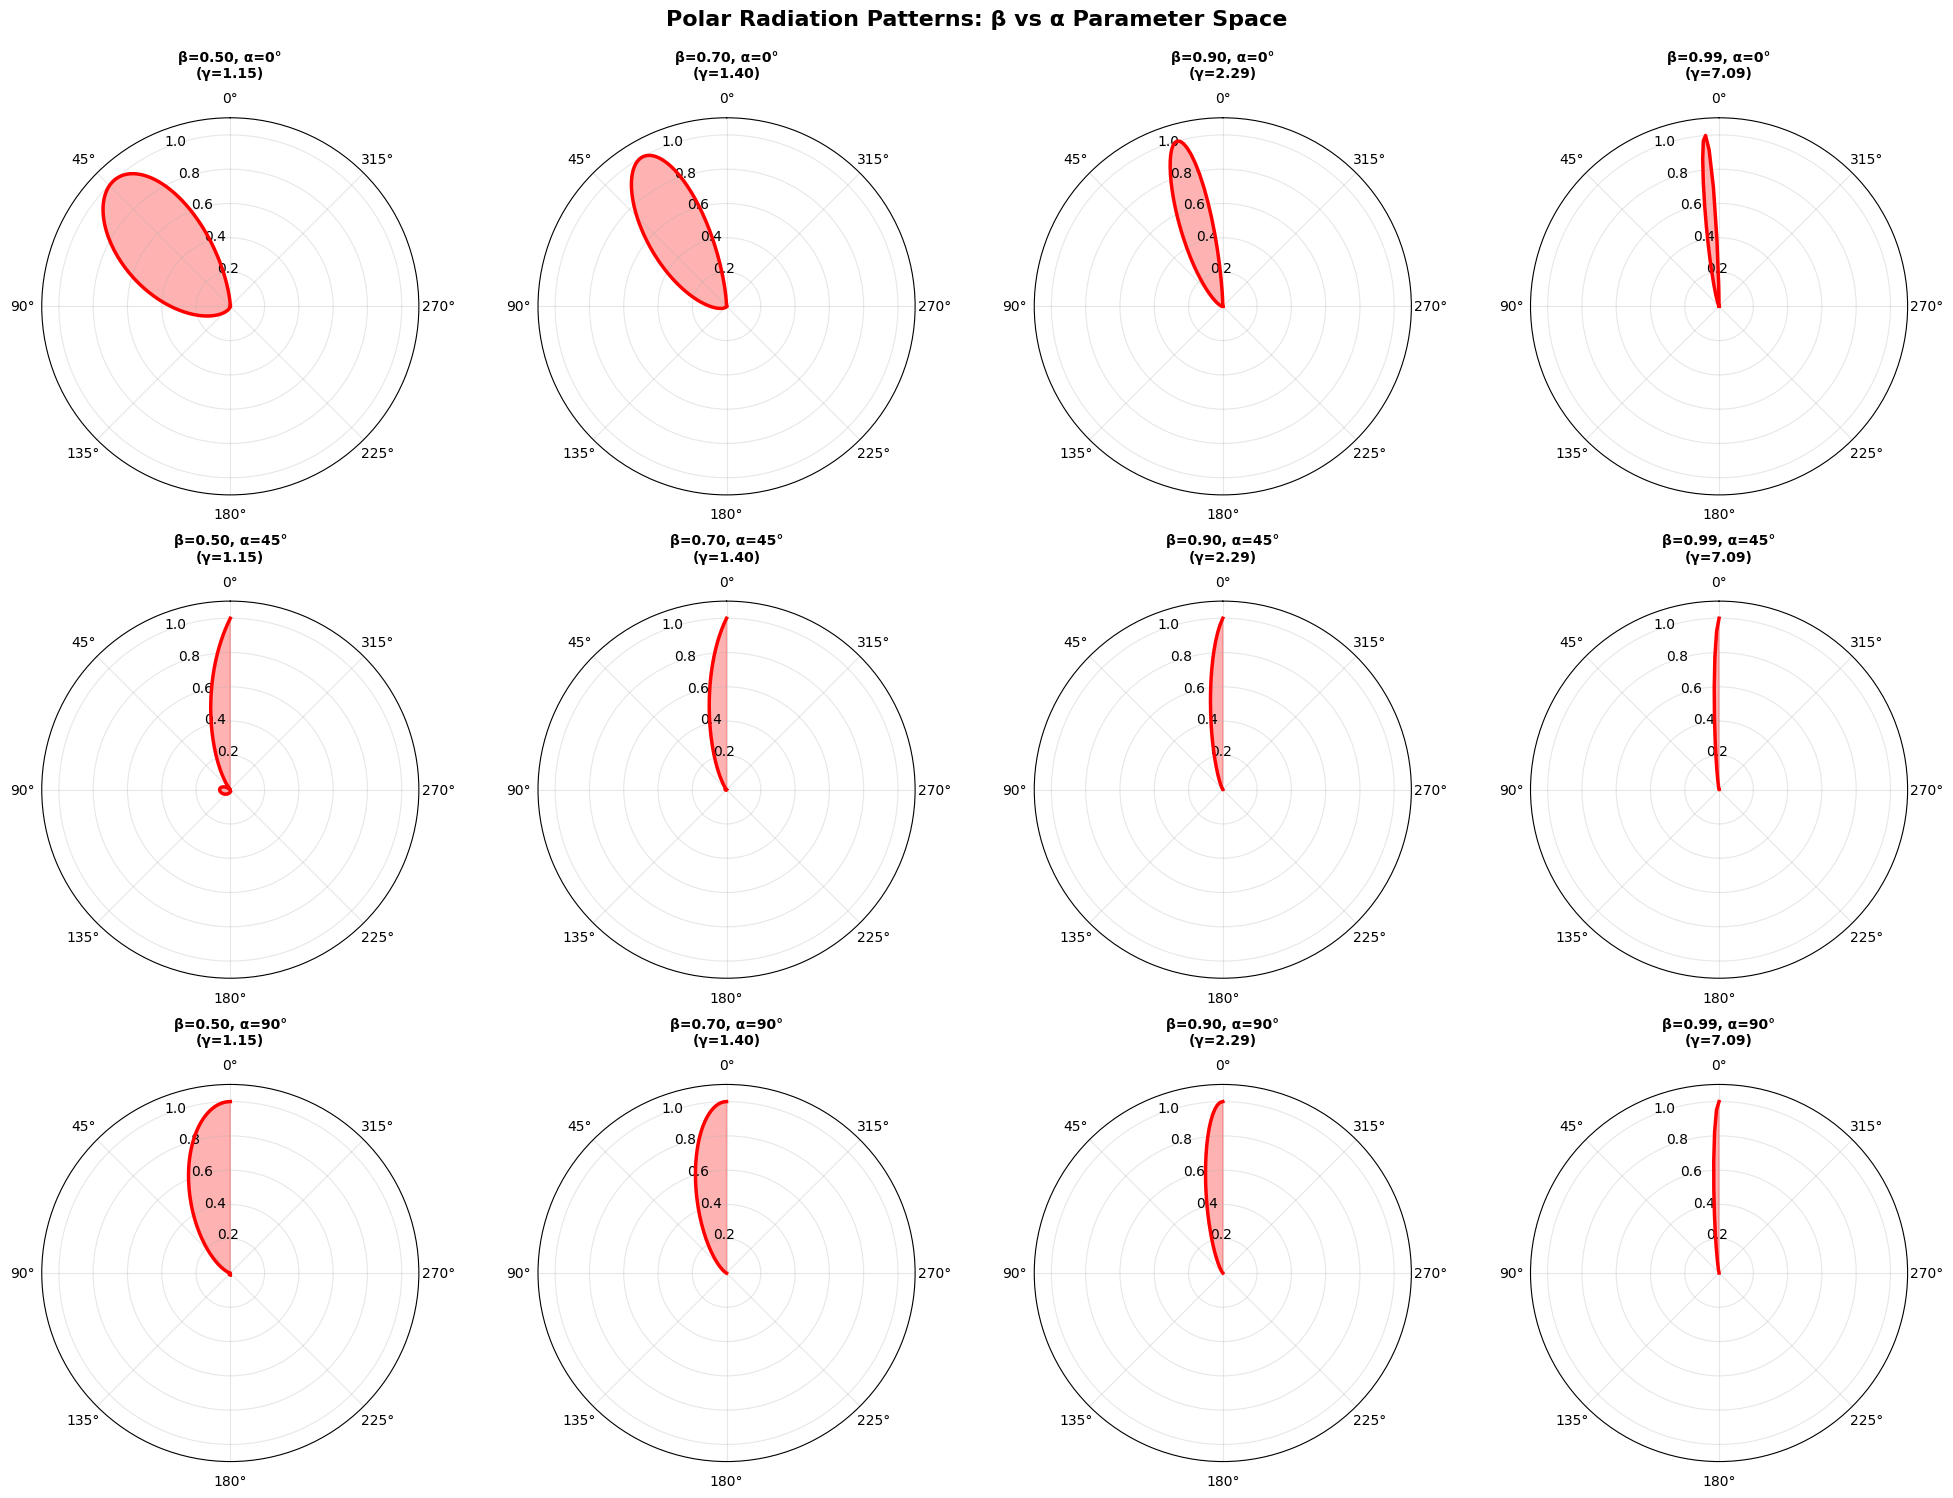

In [73]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15), subplot_kw=dict(projection='polar'))

beta_values = [0.5, 0.7, 0.9, 0.99]
alpha_values = [0, 45, 90]
phi_a_deg = 0.0

theta = np.linspace(0, np.pi, 200)

for row, alpha_deg in enumerate(alpha_values):
    for col, beta in enumerate(beta_values):
        ax = axes[row, col]
        
        alpha = np.deg2rad(alpha_deg)
        phi_a = np.deg2rad(phi_a_deg)
        gamma = 1.0 / np.sqrt(1.0 - beta**2)
        
        phi = phi_a * np.ones_like(theta)
        F = angular_distribution(theta, phi, beta, alpha, phi_a)
        F_norm = F / np.max(F)
        
        ax.plot(theta, F_norm, 'r-', linewidth=2.5)
        ax.fill(theta, F_norm, alpha=0.3, color='red')
        
        ax.set_title(f'β={beta:.2f}, α={alpha_deg:.0f}°\n(γ={gamma:.2f})', 
                    fontsize=10, fontweight='bold', pad=10)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(1)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.1)

plt.suptitle('Polar Radiation Patterns: β vs α Parameter Space', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## Grid 5 -  Ultra-Relativistic Regime

Explore extremely high velocities (β → 1) with different acceleration angles.


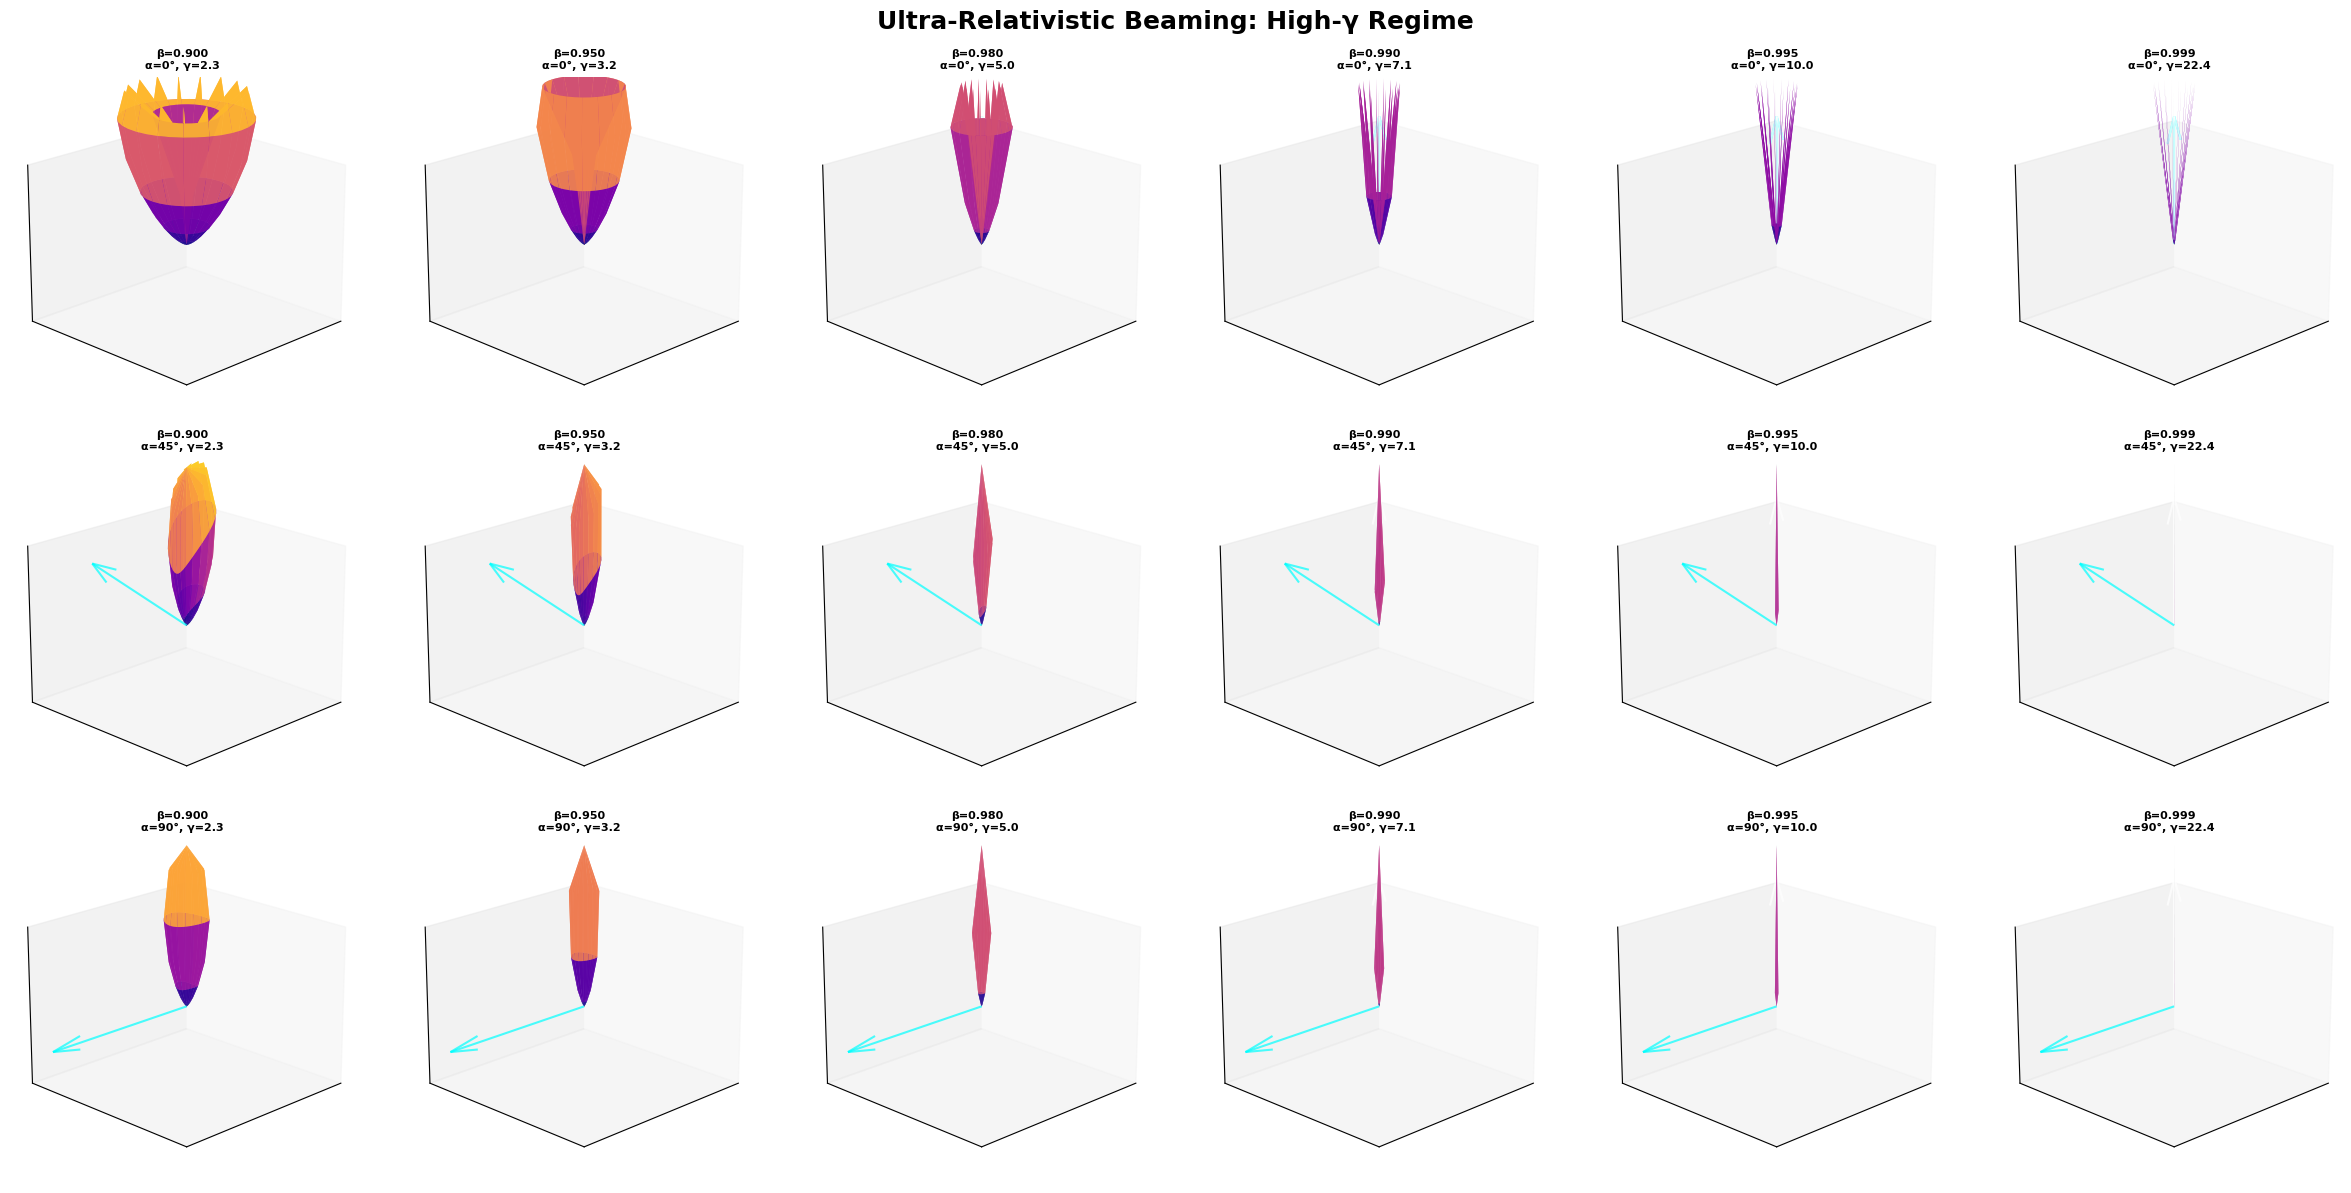

In [74]:
fig = plt.figure(figsize=(24, 12))

beta_values = [0.90, 0.95, 0.98, 0.99, 0.995, 0.999]
alpha_values = [0, 45, 90]
phi_a_deg = 0.0

plot_idx = 1
for alpha_deg in alpha_values:
    for beta in beta_values:
        ax = fig.add_subplot(3, 6, plot_idx, projection='3d')
        
        alpha = np.deg2rad(alpha_deg)
        phi_a = np.deg2rad(phi_a_deg)
        gamma = 1.0 / np.sqrt(1.0 - beta**2)
        
        n_theta = 35
        n_phi = 35
        theta_grid = np.linspace(0, np.pi, n_theta)
        phi_grid = np.linspace(0, 2*np.pi, n_phi)
        theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)
        
        F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
        F_normalized = F / np.max(F)
        x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)
        
        surf = ax.plot_surface(x, y, z, cmap='plasma', alpha=0.9, edgecolor='none',
                               vmin=0, vmax=1, rcount=25, ccount=25)
        
        acc_length = 0.8
        acc_x = acc_length * np.sin(alpha) * np.cos(phi_a)
        acc_y = acc_length * np.sin(alpha) * np.sin(phi_a)
        acc_z = acc_length * np.cos(alpha)
        ax.quiver(0, 0, 0, acc_x, acc_y, acc_z, color='cyan', arrow_length_ratio=0.2,
                  linewidth=1.5, alpha=0.7)
        ax.quiver(0, 0, 0, 0, 0, acc_length, color='white', arrow_length_ratio=0.2,
                  linewidth=1.5, alpha=0.7)
        
        title = f'β={beta:.3f}\nα={alpha_deg:.0f}°, γ={gamma:.1f}'
        ax.set_title(title, fontsize=8, fontweight='bold')
        
        ax.view_init(elev=20, azim=45)
        
        max_range = 0.5
        ax.set_xlim([-max_range, max_range])
        ax.set_ylim([-max_range, max_range])
        ax.set_zlim([-max_range, max_range])
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        plot_idx += 1

plt.suptitle('Ultra-Relativistic Beaming: High-γ Regime', 
             fontsize=18, fontweight='bold', y=0.99)
plt.tight_layout()
plt.show()


## Grid 6: Azimuthal Angle Variations

Explore different azimuthal angles (φₐ) of the acceleration direction.


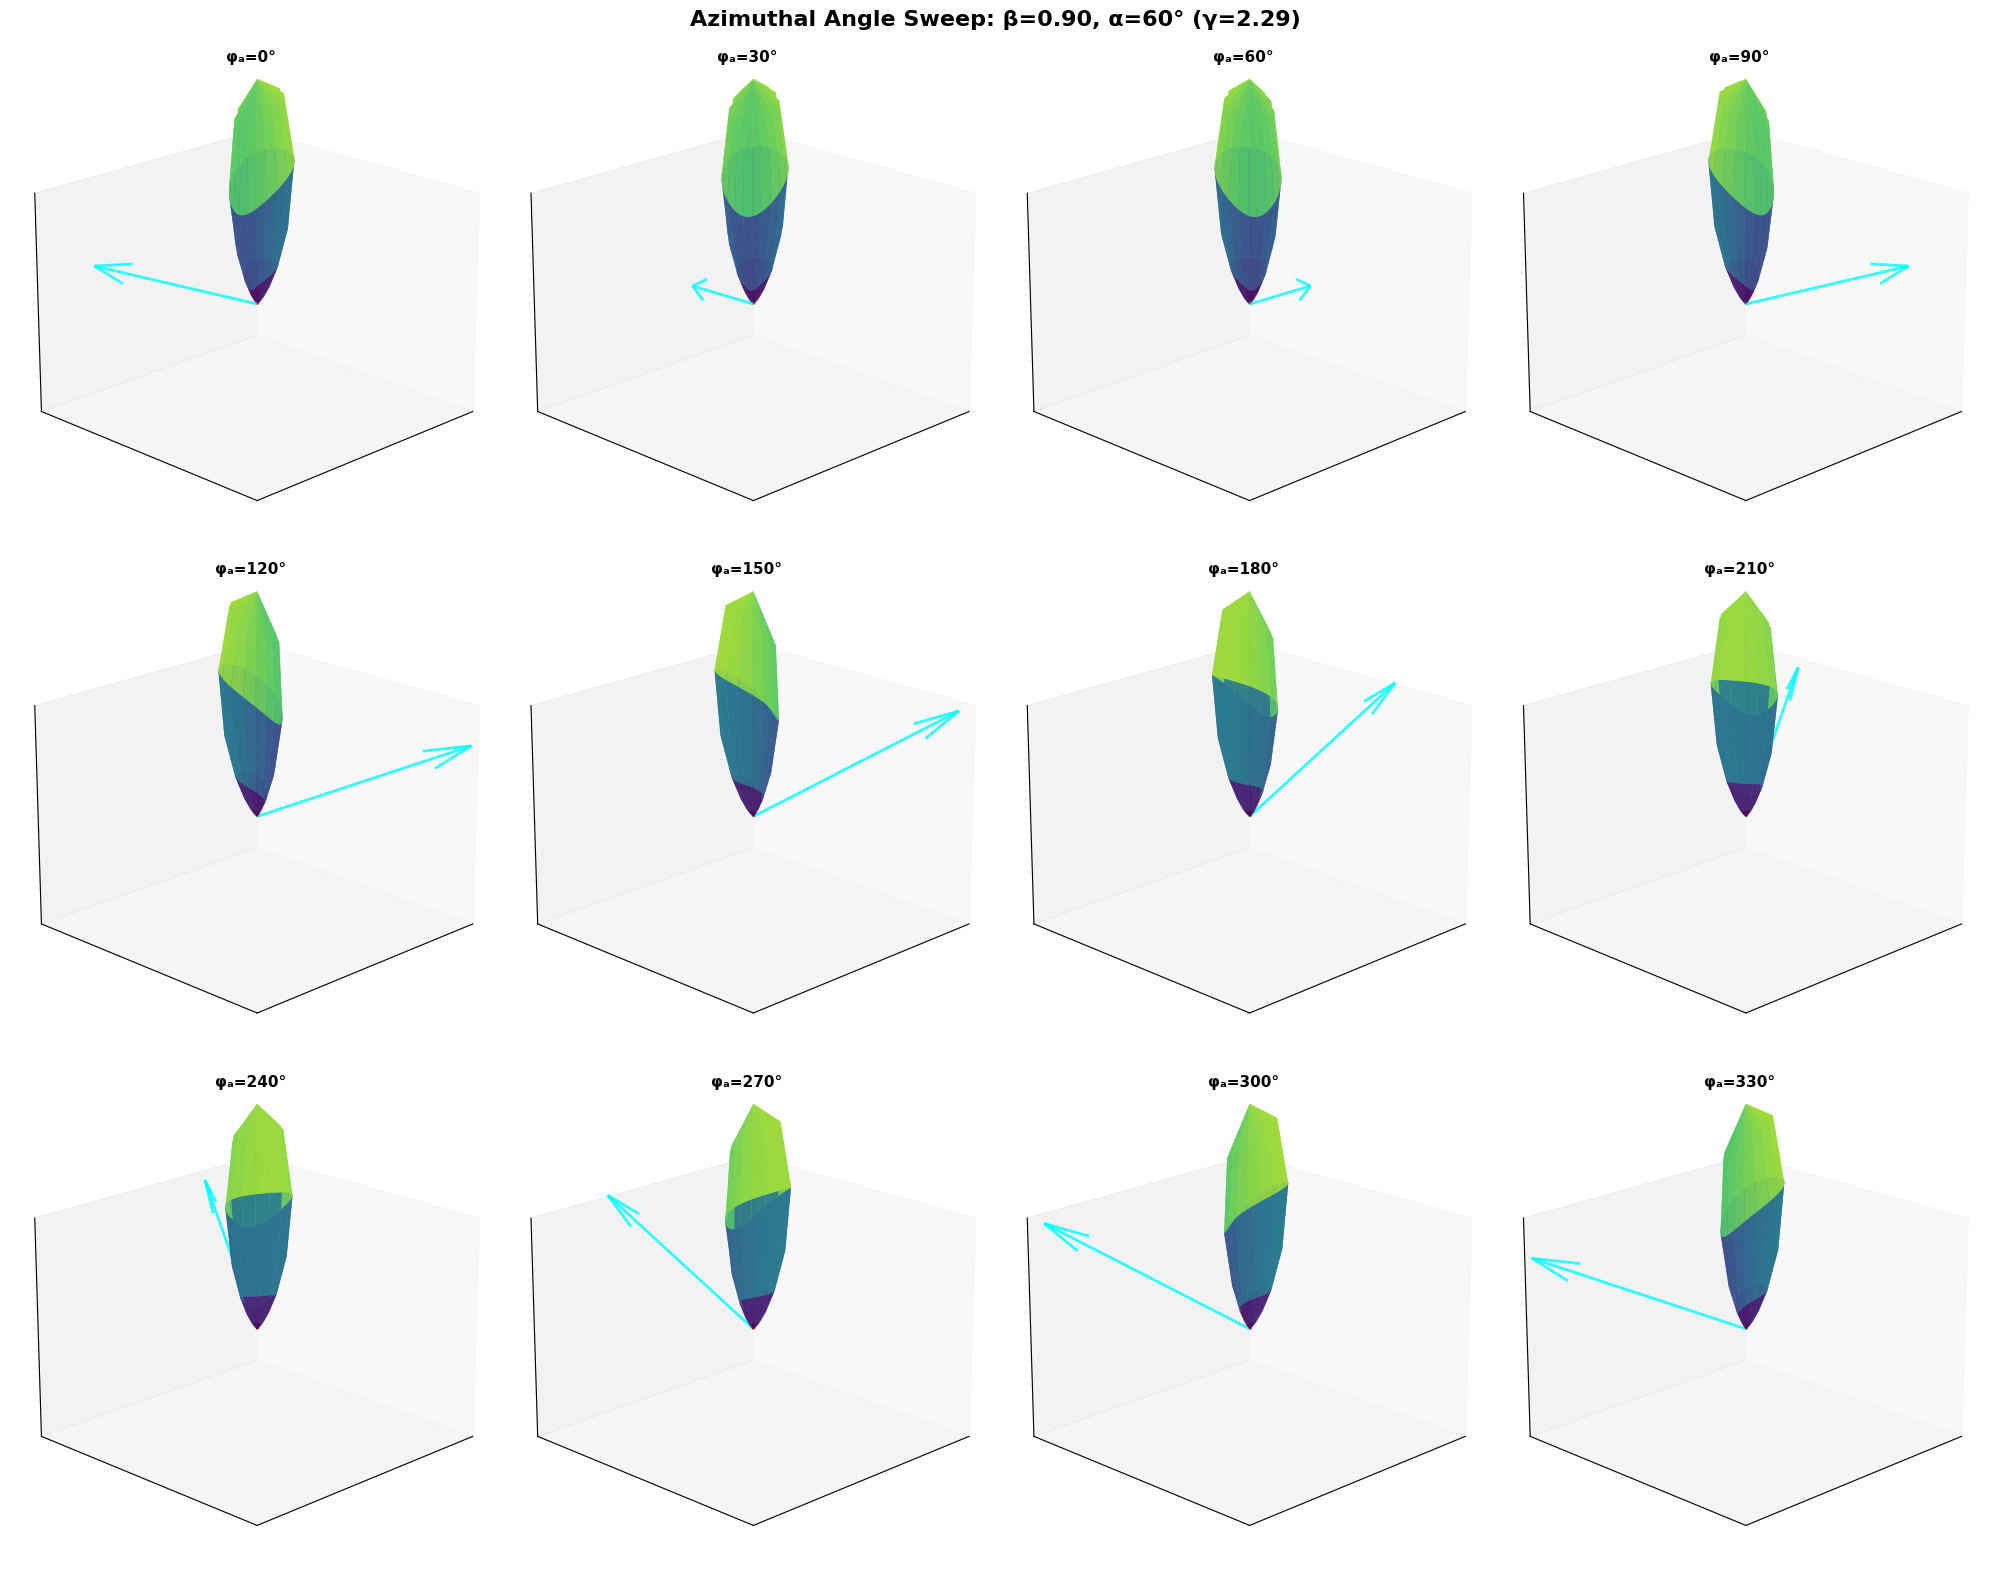

In [75]:
fig = plt.figure(figsize=(20, 16))

beta = 0.9
alpha_deg = 60.0
phi_a_values = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

for i, phi_a_deg in enumerate(phi_a_values):
    ax = fig.add_subplot(3, 4, i+1, projection='3d')
    
    alpha = np.deg2rad(alpha_deg)
    phi_a = np.deg2rad(phi_a_deg)
    gamma = 1.0 / np.sqrt(1.0 - beta**2)
    
    n_theta = 35
    n_phi = 35
    theta_grid = np.linspace(0, np.pi, n_theta)
    phi_grid = np.linspace(0, 2*np.pi, n_phi)
    theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)
    
    F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
    F_normalized = F / np.max(F)
    x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)
    
    surf = ax.plot_surface(x, y, z, cmap='viridis', alpha=0.9, edgecolor='none',
                           vmin=0, vmax=1, rcount=25, ccount=25)
    
    acc_length = 0.8
    acc_x = acc_length * np.sin(alpha) * np.cos(phi_a)
    acc_y = acc_length * np.sin(alpha) * np.sin(phi_a)
    acc_z = acc_length * np.cos(alpha)
    ax.quiver(0, 0, 0, acc_x, acc_y, acc_z, color='cyan', arrow_length_ratio=0.2,
              linewidth=2, alpha=0.8)
    ax.quiver(0, 0, 0, 0, 0, acc_length, color='red', arrow_length_ratio=0.2,
              linewidth=2, alpha=0.8)
    
    title = f'φₐ={phi_a_deg:.0f}°'
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    ax.view_init(elev=20, azim=45)
    
    max_range = 0.5
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.suptitle(f'Azimuthal Angle Sweep: β={beta:.2f}, α={alpha_deg:.0f}° (γ={gamma:.2f})', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
